In [ ]:
# Import the libs

import os
import random
import torch
import math
import numpy as np
import torch.nn as nn
import seaborn as sns
from typing import List, Tuple
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import classification_report, confusion_matrix,  precision_recall_fscore_support, balanced_accuracy_score

In [ ]:
# data managemnet

def load_data(nerdataset: str) -> Tuple[List[List[str]], List[List[str]]]:
    with open(nerdataset, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    sentences, tags = [], []
    current_sentence, current_tags = [], []

    for line in lines:
        if line.strip():
            word, tag = line.strip().split()
            current_sentence.append(word)
            current_tags.append(tag)
        else:
            if current_sentence:
                sentences.append(current_sentence)
                tags.append(current_tags)
                current_sentence, current_tags = [], []

    if current_sentence:
        sentences.append(current_sentence)
        tags.append(current_tags)

    return sentences, tags


In [ ]:
# Load raw data
sentences, tags = load_data("nerdataset.txt")

# Build word and tag vocab
word2idx = {"<PAD>": 0, "<UNK>": 1}
for sent in sentences:
    for word in sent:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

tag2idx = {}
for tag_seq in tags:
    for tag in tag_seq:
        if tag not in tag2idx:
            tag2idx[tag] = len(tag2idx)

# Inverse mapping for decoding
idx2tag = {}
for t in tag2idx:
    i = tag2idx[t]
    idx2tag[i] = t


In [4]:
# Dataset Class

class ModelDataset(Dataset):
    def __init__(self, sentences: List[List[str]], tags: List[List[str]], word2idx: dict, tag2idx: dict):
        self.sentences = sentences
        self.tags = tags
        self.word2idx = word2idx
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        x = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in self.sentences[idx]]
        y = [self.tag2idx[t] for t in self.tags[idx]]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate_fn(batch):
    sentences, tags = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences], dtype=torch.long)

    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=0)
    padded_tags = pad_sequence(tags, batch_first=True, padding_value=-100)

    return padded_sentences, padded_tags, lengths

# Create dataset
dataset = ModelDataset(sentences, tags, word2idx, tag2idx)

# Split into train/val/test
total_size = len(dataset)
test_size = int(0.2 * total_size)
train_val_size = total_size - test_size

train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [5]:
print("Total sentences in dataset:", len(dataset)) 
total_tokens = sum(len(sent) for sent, _ in [dataset[i] for i in range(len(dataset))])
print("Total tokens in dataset:", total_tokens)
print ("=============================================")
print("Total sentences in train dataset:", len(train_val_dataset)) 
total_tokens = sum(len(sent) for sent, _ in [train_val_dataset[i] for i in range(len(train_val_dataset))])
print("Total tokens in train dataset:", total_tokens)
print ("=============================================")
print("Total sentences in test dataset:", len(test_dataset)) 
total_tokens = sum(len(sent) for sent, _ in [test_dataset[i] for i in range(len(test_dataset))])
print("Total tokens in test dataset:", total_tokens)

Total sentences in dataset: 1696
Total tokens in dataset: 39007
Total sentences in train dataset: 1357
Total tokens in train dataset: 31560
Total sentences in test dataset: 339
Total tokens in test dataset: 7447


In [ ]:
# RNN

# LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=256, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = 1
        self.num_directions = 2

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, self.num_layers, 
                            bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

        nn.init.trunc_normal_(self.fc.weight, std=0.02)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, input, lengths):
        batch_size = input.size(0)

        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim).to(input.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim).to(input.device)

        embedded = self.embedding(input)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed, (h0, c0))
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        out = self.dropout(out)
        out = self.fc(out)

        return out


In [ ]:

# Transformer Model

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden, dropout=0.3):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden),
            nn.GELU(),
            nn.Linear(ff_hidden, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm, key_padding_mask=mask)
        x = x + self.dropout(attn_output)

        x_norm = self.norm2(x)
        ff_output = self.ff(x_norm)
        x = x + self.dropout(ff_output)

        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, tagset_size, d_model=128, num_layers=6, num_heads=4,
                ff_hidden=512, dropout=0.3, pad_idx=0, max_len=512):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)

        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model, num_heads, ff_hidden, dropout)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, tagset_size)

        self._init_weights()

    def forward(self, x, lengths=None):
        mask = (x == self.pad_idx)

        x = self.embedding(x)
        x = self.positional_encoding(x)

        for layer in self.transformer_layers:
            x = layer(x, mask=mask)

        x = self.dropout(x)
        logits = self.fc(x)
        return logits

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.trunc_normal_(module.weight, std=0.02)


In [ ]:
# Evaluate models
# class weighting function to calculate weights for each class

def computeClassWeights(dataset, tag2idx):
    tag_counts = Counter()
    for _, tags, _ in dataset:
        tag_counts.update(tags)

    total_count = sum(tag_counts.values())
    class_weights = []

    for tag_idx in range(len(tag2idx)):
        count = tag_counts[tag_idx]
        weight = 1.0 - (count / total_count)
        class_weights.append(weight)

    return torch.tensor(class_weights, dtype=torch.float32)


In [9]:
# Train models 

def train_model(model, dataloader, epochs=20, learning_rate=0.0025):
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    class_weights = computeClassWeights(dataloader, tag2idx)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)

    loss_history = []
    accuracy_history = []

    
    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0

        for x_batch, y_batch, lengths in dataloader:
            optimizer.zero_grad()
            outputs = model(x_batch, lengths)
            predictions = outputs.argmax(dim=-1)

            outputs_flat = outputs.view(-1, outputs.shape[-1])
            y_batch_flat = y_batch.view(-1)

            loss = loss_fn(outputs_flat, y_batch_flat)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            mask = y_batch != -100
            correct += ((predictions == y_batch) & mask).sum().item()
            total += mask.sum().item()

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)


    return loss_history, accuracy_history


In [10]:
# Evaluate models

def evaluate_model(model, dataloader, idx2tag):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch, lengths in dataloader:
            outputs = model(x_batch, lengths)
            predictions = outputs.argmax(dim=-1)

            for i in range(len(lengths)):
                length = lengths[i]
                true_seq = y_batch[i][:length]
                pred_seq = predictions[i][:length]

                for t, p in zip(true_seq, pred_seq):
                    if t.item() != -100:
                        y_true.append(t.item())
                        y_pred.append(p.item())
                
    y_true_labels = [idx2tag[i] for i in y_true]
    y_pred_labels = [idx2tag[i] for i in y_pred]

    valid_labels = list(tag2idx.keys())

    print("Classification Report:")
    print(classification_report(
        y_true_labels, y_pred_labels, labels=valid_labels, digits=4, zero_division=0
    ))

    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=valid_labels)


    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_true_labels, y_pred_labels, average='macro', zero_division=0
    )

    return macro_precision, macro_recall, macro_f1, cm


In [11]:
# Validate models

def kFoldCrossValidation(train_val_dataset, model_class, k=5, epochs=20, batch_size=32, learning_rate=0.0025):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_metrics = []
    all_loss_histories = []
    all_accuracy_histories = []
    best_f1 = -1.0
    best_model_state = None

    for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_dataset)):
        print(f"\nFold {fold + 1}/{k}")

        train_subset = Subset(train_val_dataset, train_indices)
        val_subset = Subset(train_val_dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_subset, batch_size=batch_size, collate_fn=collate_fn)

        model = model_class(len(word2idx), len(tag2idx))

        loss_history, accuracy_history = train_model(
            model,
            train_loader,
            epochs=epochs,
            learning_rate=learning_rate,
        )
        
        all_loss_histories.append(loss_history)
        all_accuracy_histories.append(accuracy_history)

        precision, recall, f1, _ = evaluate_model(model, val_loader, idx2tag)
        all_metrics.append((precision, recall, f1))

        if f1 > best_f1:
            best_f1 = f1
            best_model_state = model.state_dict()

    avg_precision = np.mean([m[0] for m in all_metrics])
    avg_recall = np.mean([m[1] for m in all_metrics])
    avg_f1 = np.mean([m[2] for m in all_metrics])

    print(f"\nAverage across {k} folds:")
    print(f"Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-score: {avg_f1:.4f}")

    return all_loss_histories, all_accuracy_histories, best_model_state



Fold 1/5
Classification Report:
              precision    recall  f1-score   support

      I-MISC     0.2869    0.6322    0.3947       329
           O     0.9657    0.9321    0.9486      5642
       I-ORG     0.6614    0.6413    0.6512       329
       I-PER     0.8916    0.5543    0.6836       267
       I-LOC     0.8171    0.5296    0.6427       253

    accuracy                         0.8739      6820
   macro avg     0.7245    0.6579    0.6642      6820
weighted avg     0.9098    0.8739    0.8858      6820

Balanced Accuracy Score: 0.6579


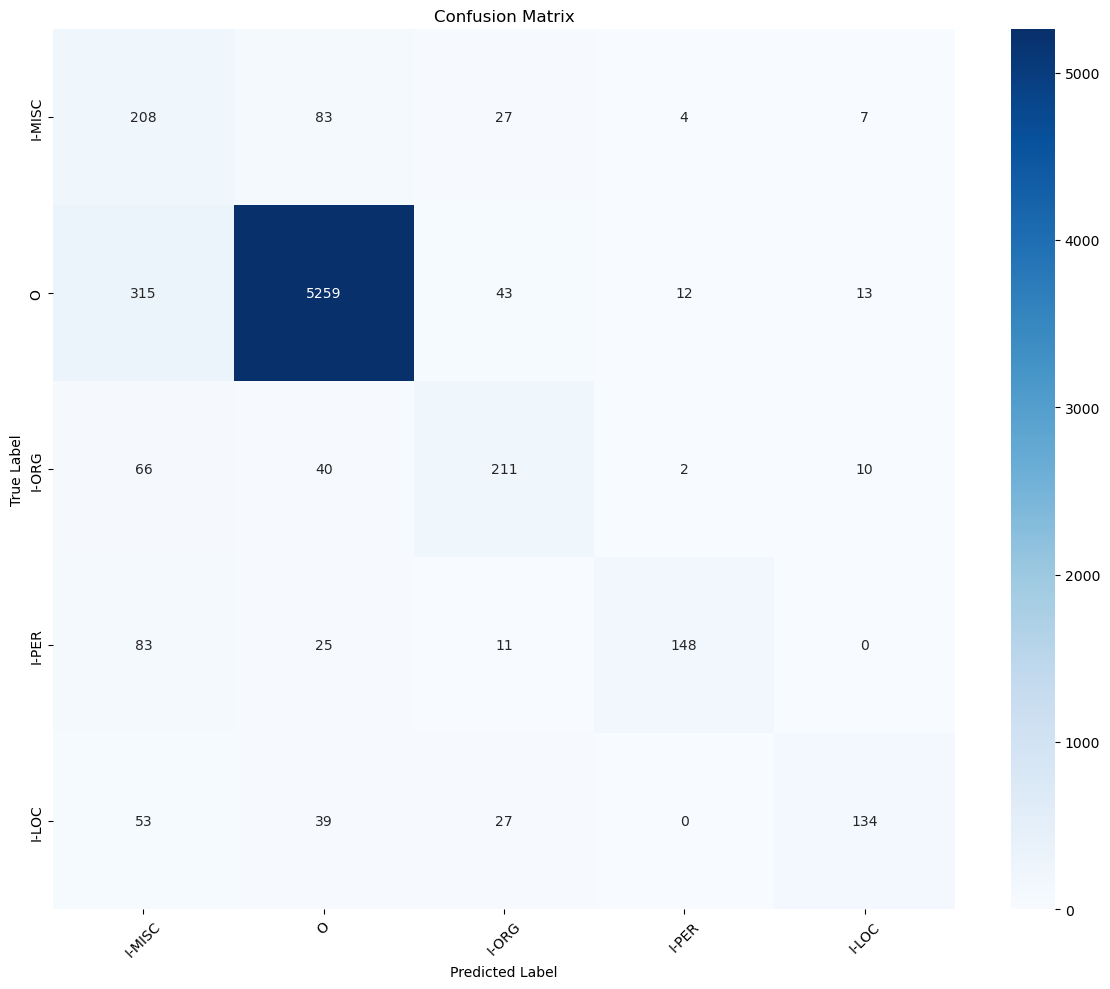


Fold 2/5
Classification Report:
              precision    recall  f1-score   support

      I-MISC     0.3684    0.6738    0.4764       187
           O     0.9635    0.9733    0.9683      5312
       I-ORG     0.7828    0.5877    0.6714       325
       I-PER     0.8616    0.5394    0.6634       254
       I-LOC     0.7195    0.5990    0.6537       197

    accuracy                         0.9151      6275
   macro avg     0.7392    0.6746    0.6866      6275
weighted avg     0.9246    0.9151    0.9161      6275

Balanced Accuracy Score: 0.6746


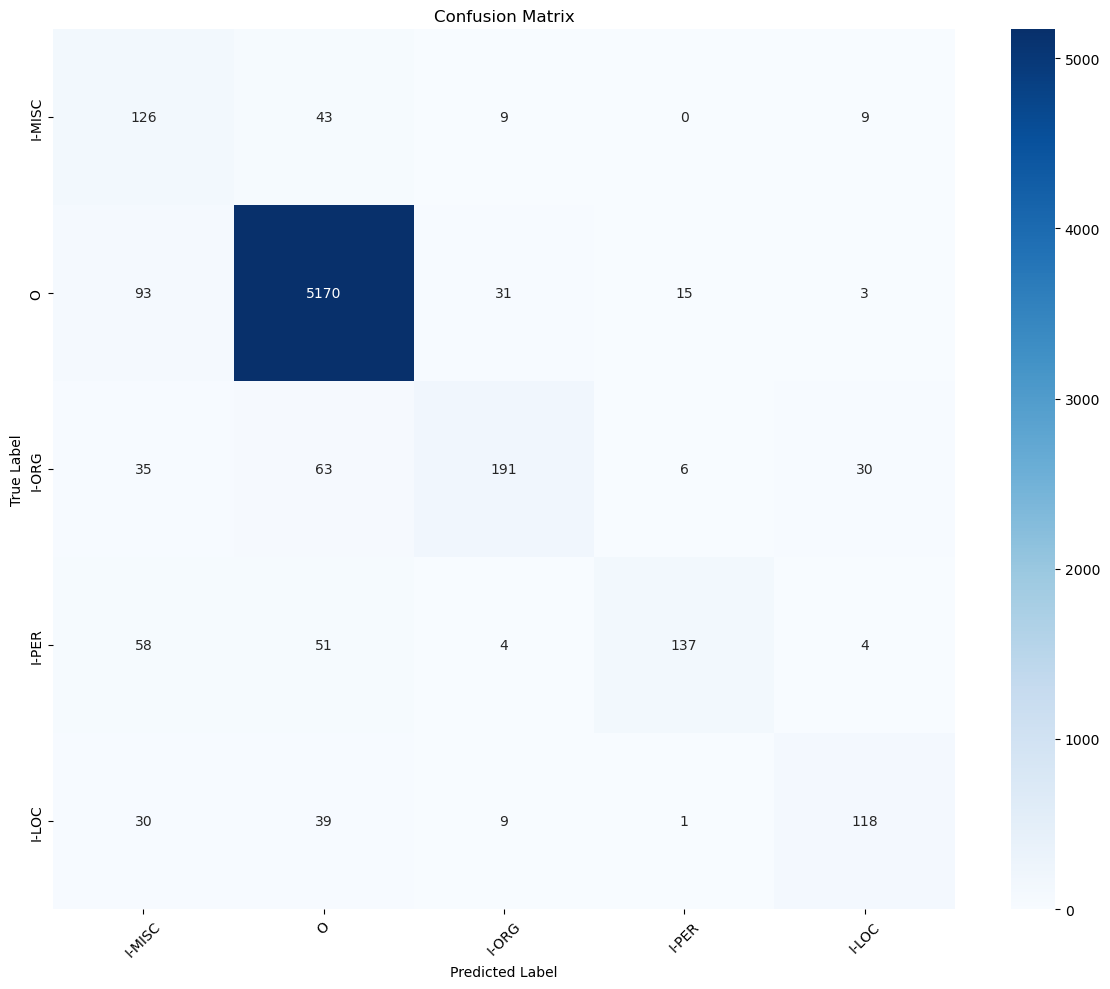


Fold 3/5
Classification Report:
              precision    recall  f1-score   support

      I-MISC     0.2784    0.5631    0.3726       222
           O     0.9605    0.9506    0.9555      5300
       I-ORG     0.7662    0.6138    0.6816       347
       I-PER     0.8718    0.6967    0.7745       244
       I-LOC     0.8544    0.6368    0.7297       212

    accuracy                         0.8982      6325
   macro avg     0.7463    0.6922    0.7028      6325
weighted avg     0.9189    0.8982    0.9055      6325

Balanced Accuracy Score: 0.6922


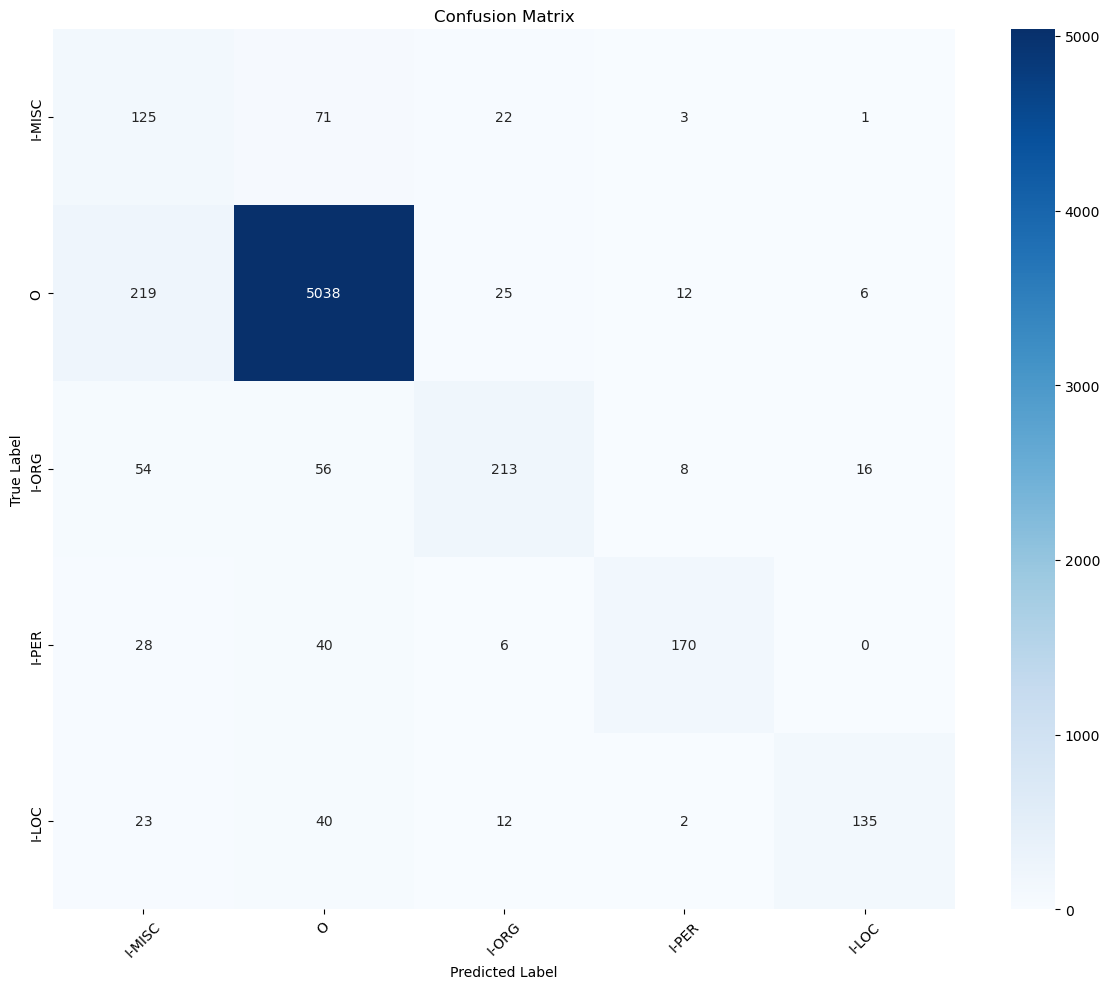


Fold 4/5
Classification Report:
              precision    recall  f1-score   support

      I-MISC     0.3254    0.6538    0.4345       208
           O     0.9635    0.9591    0.9613      5309
       I-ORG     0.7829    0.5781    0.6650       237
       I-PER     0.8355    0.6587    0.7366       293
       I-LOC     0.8456    0.5972    0.7000       211

    accuracy                         0.9083      6258
   macro avg     0.7506    0.6894    0.6995      6258
weighted avg     0.9255    0.9083    0.9132      6258

Balanced Accuracy Score: 0.6894


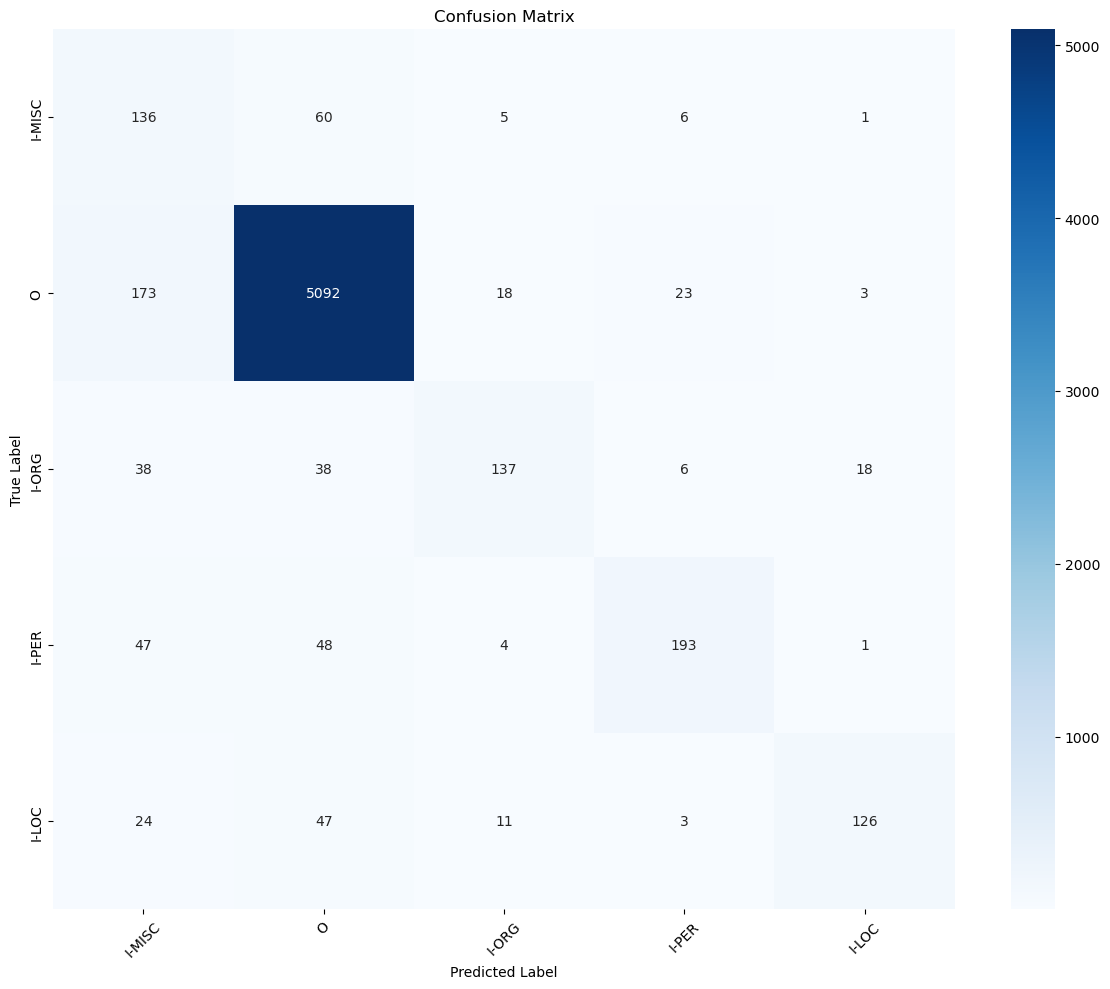


Fold 5/5
Classification Report:
              precision    recall  f1-score   support

      I-MISC     0.2871    0.6070    0.3898       201
           O     0.9508    0.9591    0.9549      4839
       I-ORG     0.8278    0.4408    0.5753       338
       I-PER     0.8066    0.6502    0.7200       263
       I-LOC     0.8315    0.6349    0.7200       241

    accuracy                         0.8902      5882
   macro avg     0.7408    0.6584    0.6720      5882
weighted avg     0.9097    0.8902    0.8937      5882

Balanced Accuracy Score: 0.6584


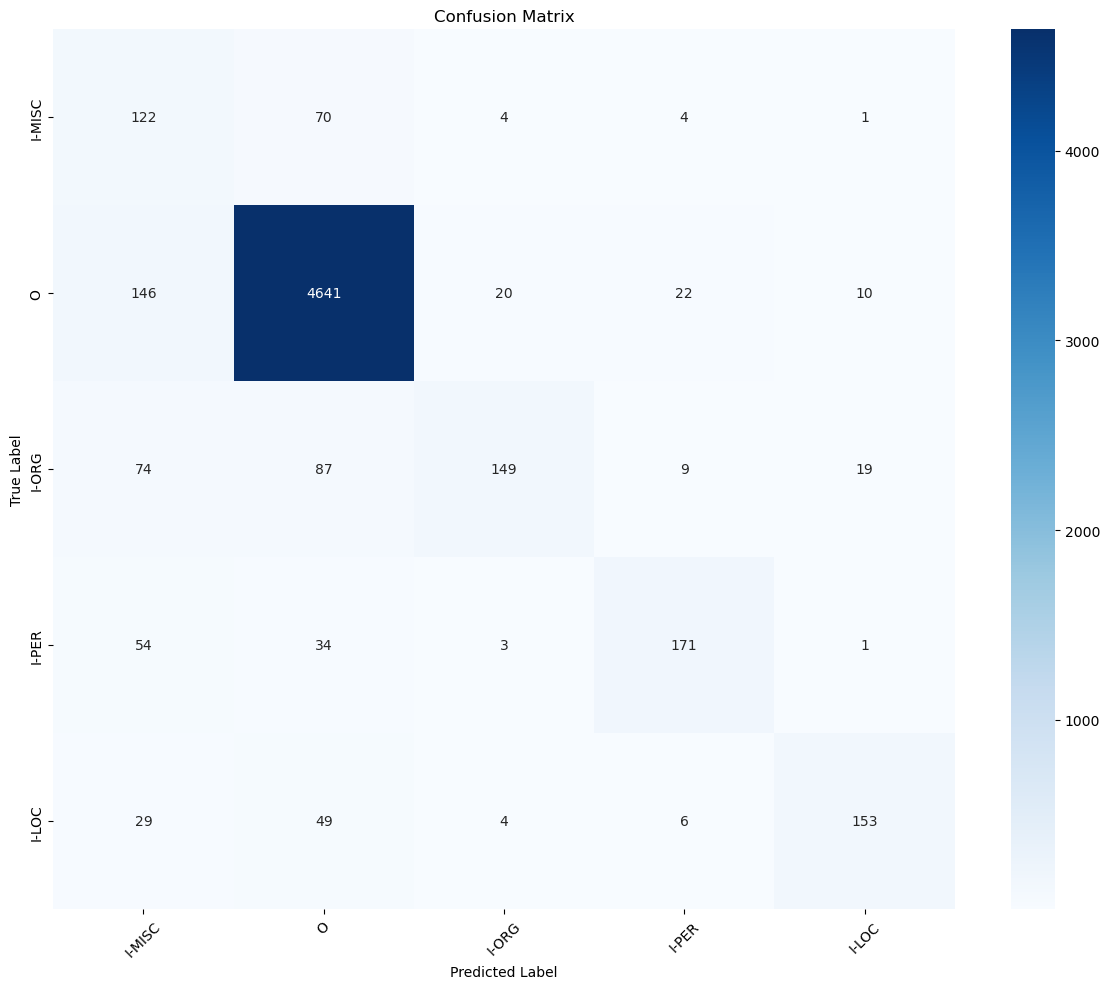


Average across 5 folds:
Precision: 0.7403, Recall: 0.6745, F1-score: 0.6850


LSTMModel(
  (embedding): Embedding(8506, 100, padding_idx=0)
  (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

In [12]:


loss_histories, acc_histories, best_model_state = kFoldCrossValidation(train_val_dataset, LSTMModel)
#loss_histories, acc_histories, best_model_state = kFoldCrossValidation(train_val_dataset, TransformerModel)

# Load the best model
best_model = LSTMModel(len(word2idx), len(tag2idx))
#best_model = TransformerModel(len(word2idx), len(tag2idx))

best_model.load_state_dict(best_model_state)
best_model.eval()


In [ ]:
# Plot loss and accuracy

def plot_metrics(all_loss_histories, all_accuracy_histories):
    k = len(all_loss_histories)
    epochs = len(all_loss_histories[0])
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    for i in range(k):
        plt.plot(range(1, epochs + 1), all_loss_histories[i], label=f'Fold {i + 1}')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    for i in range(k):
        plt.plot(range(1, epochs + 1), all_accuracy_histories[i], label=f'Fold {i + 1}')
    plt.title("Training Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_metrics(loss_histories, acc_histories)

In [ ]:
# Test model

precision, recall, f1, _ = evaluate_model(best_model, test_loader, idx2tag)
print(f"Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")